In [ ]:
# =========================
# 4.1 Experimental Setup
# =========================
import sys, platform, tensorflow as tf, sklearn, pandas as pd, numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping

print("Python version:", platform.python_version())
print("TensorFlow version:", tf.__version__)
print("Scikit-learn version:", sklearn.__version__)
print("Pandas version:", pd.__version__)
print("NumPy version:", np.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

Python version: 3.12.11
TensorFlow version: 2.19.0
Scikit-learn version: 1.6.1
Pandas version: 2.2.2
NumPy version: 2.0.2
GPU Available: []


In [ ]:
# =========================
# 4.2 Dataset Loading
# =========================

from google.colab import files
import pandas as pd

# Upload the dataset manually
uploaded = files.upload()

# Get the filename automatically (first uploaded file)
filename = list(uploaded.keys())[0]

# Load dataset
df = pd.read_csv(filename)

# Quick look at the data
print("Shape:", df.shape)
print(df.head())
print(df.info())


Saving pollution_2000_2023.csv to pollution_2000_2023.csv
Shape: (665414, 22)
   Unnamed: 0        Date                                  Address    State  \
0           0  2000-01-01  1645 E ROOSEVELT ST-CENTRAL PHOENIX STN  Arizona   
1           1  2000-01-02  1645 E ROOSEVELT ST-CENTRAL PHOENIX STN  Arizona   
2           2  2000-01-03  1645 E ROOSEVELT ST-CENTRAL PHOENIX STN  Arizona   
3           3  2000-01-04  1645 E ROOSEVELT ST-CENTRAL PHOENIX STN  Arizona   
4           4  2000-01-05  1645 E ROOSEVELT ST-CENTRAL PHOENIX STN  Arizona   

     County     City   O3 Mean  O3 1st Max Value  O3 1st Max Hour  O3 AQI  \
0  Maricopa  Phoenix  0.019765             0.040               10      37   
1  Maricopa  Phoenix  0.015882             0.032               10      30   
2  Maricopa  Phoenix  0.009353             0.016                9      15   
3  Maricopa  Phoenix  0.015882             0.033                9      31   
4  Maricopa  Phoenix  0.007353             0.012              

In [ ]:
print("Dataset Shape:", df.shape)
print("Columns:", df.columns.tolist())
print(df.head())


Dataset Shape: (665414, 22)
Columns: ['Unnamed: 0', 'Date', 'Address', 'State', 'County', 'City', 'O3 Mean', 'O3 1st Max Value', 'O3 1st Max Hour', 'O3 AQI', 'CO Mean', 'CO 1st Max Value', 'CO 1st Max Hour', 'CO AQI', 'SO2 Mean', 'SO2 1st Max Value', 'SO2 1st Max Hour', 'SO2 AQI', 'NO2 Mean', 'NO2 1st Max Value', 'NO2 1st Max Hour', 'NO2 AQI']
   Unnamed: 0        Date                                  Address    State  \
0           0  2000-01-01  1645 E ROOSEVELT ST-CENTRAL PHOENIX STN  Arizona   
1           1  2000-01-02  1645 E ROOSEVELT ST-CENTRAL PHOENIX STN  Arizona   
2           2  2000-01-03  1645 E ROOSEVELT ST-CENTRAL PHOENIX STN  Arizona   
3           3  2000-01-04  1645 E ROOSEVELT ST-CENTRAL PHOENIX STN  Arizona   
4           4  2000-01-05  1645 E ROOSEVELT ST-CENTRAL PHOENIX STN  Arizona   

     County     City   O3 Mean  O3 1st Max Value  O3 1st Max Hour  O3 AQI  \
0  Maricopa  Phoenix  0.019765             0.040               10      37   
1  Maricopa  Phoenix  0.0

In [ ]:
# file: pollution_forecasting.py
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
# =========================
# 2. Preprocessing
# =========================

import pandas as pd
import numpy as np

df = df.copy()  # Work on a copy

# --------------------------
# Step 1: Identify datetime column
# --------------------------
datetime_col = None
for c in df.columns:
    if c == 'Date' or 'date' in c.lower() or 'time' in c.lower():
        datetime_col = c
        break

if datetime_col:
    # Convert to datetime if available
    df[datetime_col] = pd.to_datetime(df[datetime_col], errors='coerce')
    df = df.dropna(subset=[datetime_col])
    df = df.set_index(datetime_col).sort_index()
else:
    # No datetime column → create safe artificial timeline
    datetime_col = "date"
    date_range = pd.date_range("2000-01-01", "2023-12-31", freq="D")

    # Assign dates cyclically (safe for very large datasets)
    df[datetime_col] = [date_range[i % len(date_range)] for i in range(len(df))]
    df = df.set_index(datetime_col).sort_index()

# --------------------------
# Step 2: Identify region column
# --------------------------
region_col = None
for c in df.columns:
    if any(word in c.lower() for word in ["state", "county", "city", "region"]):
        region_col = c
        break

if not region_col:
    df["region"] = "US"
    region_col = "region"

# --------------------------
# Step 3: Select target pollutant
# --------------------------
possible_targets = ["O3", "NO2", "SO2", "CO", "pm25", "pm10"]
target_col = None
for c in df.columns:
    if c.upper() in [p.upper() for p in possible_targets]:
        target_col = c
        break

if not target_col:
    num_cols = df.select_dtypes(include=np.number).columns
    if len(num_cols) == 0:
        raise ValueError("No numeric columns found for target variable.")
    target_col = num_cols[0]

print(" Using target pollutant:", target_col)

# --------------------------
# Step 4: Handle missing values & resample daily
# --------------------------
processed_dfs = []

for region, group in df.groupby(region_col):
    if not group.empty:
        # Select numeric cols only
        numeric_cols = group.select_dtypes(include=np.number).columns.tolist()

        if target_col not in numeric_cols:
            raise ValueError(f"Target column {target_col} is not numeric.")

        # Fill missing values
        group[numeric_cols] = group[numeric_cols].interpolate().bfill().ffill()

        # Resample numeric values daily
        group_resampled = group[numeric_cols].resample("D").mean()

        # Add region info
        group_resampled[region_col] = region

        # Add datetime features
        group_resampled["year"] = group_resampled.index.year
        group_resampled["month"] = group_resampled.index.month
        group_resampled["dayofweek"] = group_resampled.index.dayofweek

        # Lag features
        for lag in [1, 7, 30]:
            group_resampled[f"{target_col}_lag{lag}"] = group_resampled[target_col].shift(lag)

        # Rolling averages
        for win in [7, 30]:
            group_resampled[f"{target_col}_roll{win}"] = group_resampled[target_col].rolling(win).mean()

        processed_dfs.append(group_resampled.reset_index())

# --------------------------
# Step 5: Concatenate back
# --------------------------
if processed_dfs:
    df = pd.concat(processed_dfs, ignore_index=True)
    df[datetime_col] = pd.to_datetime(df[datetime_col], errors='coerce')
else:
    df = pd.DataFrame()

df = df.dropna()

print(" Preprocessed data:", df.shape)
print(df.head())


🎯 Using target pollutant: Unnamed: 0
✅ Preprocessed data: (26056, 27)
            date  Unnamed: 0   O3 Mean  O3 1st Max Value  O3 1st Max Hour  \
17550 2000-01-31    252635.0  0.031779            0.0465            10.25   
17551 2000-02-01    268614.5  0.048470            0.0615            17.00   
17552 2000-02-02    527324.0  0.009765            0.0230            10.00   
17553 2000-02-03    234125.4  0.030165            0.0434             9.80   
17554 2000-02-04    183438.5  0.024324            0.0410             9.50   

       O3 AQI   CO Mean  CO 1st Max Value  CO 1st Max Hour  CO AQI  ...  \
17550   50.25  0.475000             0.725             2.75    8.25  ...   
17551   90.00  0.283334             0.350             4.00    4.00  ...   
17552   21.00  0.620833             1.100             1.00   13.00  ...   
17553   41.20  0.291667             0.380             2.00    4.20  ...   
17554   37.50  0.322916             0.450             0.00    5.50  ...   

       NO2 AQI  

In [ ]:
# =========================
# 4.3 Train / Test Split
# =========================
X = df.drop(columns=[target_col])
y = df[target_col]

split1 = int(len(df) * 0.7)
split2 = int(len(df) * 0.85)
X_train, X_val, X_test = X.iloc[:split1], X.iloc[split1:split2], X.iloc[split2:]
y_train, y_val, y_test = y.iloc[:split1], y.iloc[split1:split2], y.iloc[split2:]

print(
    "Train size:", len(X_train),
    "Validation size:", len(X_val),
    "Test size:", len(X_test)
)

Train size: 18239 Validation size: 3908 Test size: 3909


In [ ]:
# =========================
# 4.4 Baseline Models
# =========================

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Drop datetime columns from training features (keep only numeric)
X_train_num = X_train.select_dtypes(include=[np.number])
X_test_num = X_test.select_dtypes(include=[np.number])

# --- Naive Persistence (previous value as prediction)
y_pred_naive = df[target_col].shift(1).iloc[split2:]
mae_naive = mean_absolute_error(y_test, y_pred_naive)
rmse_naive = np.sqrt(mean_squared_error(y_test, y_pred_naive))

# --- Linear Regression
linreg = LinearRegression().fit(X_train_num, y_train)
y_pred_lr = linreg.predict(X_test_num)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

# --- Random Forest
rf = RandomForestRegressor(n_estimators=50, random_state=42).fit(X_train_num, y_train)
y_pred_rf = rf.predict(X_test_num)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

# --- Results
print("✅ Baseline Models Comparison")
print(f"Naive -> MAE: {mae_naive:.3f}, RMSE: {rmse_naive:.3f}")
print(f"Linear Regression -> MAE: {mae_lr:.3f}, RMSE: {rmse_lr:.3f}")
print(f"Random Forest -> MAE: {mae_rf:.3f}, RMSE: {rmse_rf:.3f}")


✅ Baseline Models Comparison
Naive -> MAE: 110620.645, RMSE: 141420.799
Linear Regression -> MAE: 64225.889, RMSE: 83520.398
Random Forest -> MAE: 73663.261, RMSE: 94942.828


In [ ]:
# =========================
# 4.5 Deep Learning Models
# =========================

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping

# --- Keep only numeric columns for X
X_num = X.select_dtypes(include=[np.number])
y_num = y.copy()   # target is already numeric (pollutant values)

# --- Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)

# --- Sequence creation function
def create_sequences(X, y, seq_length=30):
    Xs, ys = [], []
    for i in range(len(X) - seq_length):
        Xs.append(X[i:i+seq_length])
        ys.append(y.iloc[i+seq_length])
    return np.array(Xs), np.array(ys)

# --- Create sequences
seq_length = 30
X_seq, y_seq = create_sequences(X_scaled, y_num, seq_length)

# --- Train/Val/Test Split
train_end = int(len(X_seq) * 0.7)
val_end = int(len(X_seq) * 0.85)

X_train_seq, y_train_seq = X_seq[:train_end], y_seq[:train_end]
X_val_seq, y_val_seq = X_seq[train_end:val_end], y_seq[train_end:val_end]
X_test_seq, y_test_seq = X_seq[val_end:], y_seq[val_end:]

# --- LSTM Model
lstm = Sequential([
    LSTM(64, return_sequences=True, input_shape=(seq_length, X_seq.shape[2])),
    LSTM(32),
    Dense(1)
])
lstm.compile(optimizer="adam", loss="mse")
history_lstm = lstm.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=20, batch_size=32,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
    verbose=1
)
y_pred_lstm = lstm.predict(X_test_seq)
rmse_lstm = np.sqrt(mean_squared_error(y_test_seq, y_pred_lstm))

# --- GRU Model
gru = Sequential([
    GRU(64, return_sequences=True, input_shape=(seq_length, X_seq.shape[2])),
    GRU(32),
    Dense(1)
])
gru.compile(optimizer="adam", loss="mse")
history_gru = gru.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=20, batch_size=32,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
    verbose=1
)
y_pred_gru = gru.predict(X_test_seq)
rmse_gru = np.sqrt(mean_squared_error(y_test_seq, y_pred_gru))

# --- Results
print("✅ Deep Learning Models Results")
print(f"LSTM RMSE: {rmse_lstm:.3f}")
print(f"GRU RMSE: {rmse_gru:.3f}")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
570/570 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - loss: 79188451328.0000 - val_loss: 96670588928.0000
Epoch 2/20
570/570 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - loss: 79047450624.0000 - val_loss: 96661749760.0000
Epoch 3/20
570/570 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - loss: 78863613952.0000 - val_loss: 96653008896.0000
Epoch 4/20
570/570 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - loss: 78934786048.0000 - val_loss: 96644169728.0000
Epoch 5/20
570/570 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - loss: 78949171200.0000 - val_loss: 96635338752.0000
Epoch 6/20
570/570 ━━━━━━━━━━━━━━━━━━━━ 19s 32ms/step - loss: 79470690304.0000 - val_loss: 96626409472.0000
Epoch 7/20
570/570 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - loss: 78973001728.0000 - val_loss: 96617406464.0000
Epoch 8/20
570/570 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - loss: 79040430080.0000 - val_loss: 96608346112.0000
Epoch 9/20
570/570 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - loss: 79179661312.0000 - val_loss: 96599269376.0000
Epoch 10/20
570/570 ━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


570/570 ━━━━━━━━━━━━━━━━━━━━ 28s 42ms/step - loss: 78759772160.0000 - val_loss: 96675438592.0000
Epoch 2/20
570/570 ━━━━━━━━━━━━━━━━━━━━ 39s 38ms/step - loss: 79095201792.0000 - val_loss: 96670736384.0000
Epoch 3/20
570/570 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - loss: 79112241152.0000 - val_loss: 96666132480.0000
Epoch 4/20
570/570 ━━━━━━━━━━━━━━━━━━━━ 22s 39ms/step - loss: 78623154176.0000 - val_loss: 96661610496.0000
Epoch 5/20
570/570 ━━━━━━━━━━━━━━━━━━━━ 42s 41ms/step - loss: 78881193984.0000 - val_loss: 96657113088.0000
Epoch 6/20
570/570 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - loss: 78638473216.0000 - val_loss: 96652509184.0000
Epoch 7/20
570/570 ━━━━━━━━━━━━━━━━━━━━ 23s 41ms/step - loss: 78496432128.0000 - val_loss: 96647938048.0000
Epoch 8/20
570/570 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - loss: 78145675264.0000 - val_loss: 96643366912.0000
Epoch 9/20
570/570 ━━━━━━━━━━━━━━━━━━━━ 38s 35ms/step - loss: 79111102464.0000 - val_loss: 96638812160.0000
Epoch 10/20
570/570 ━━━━━━━━━━━━━━━━━━━

In [ ]:
# =========================
# 4.6 Results Summary
# =========================
results = pd.DataFrame({
    "Model": ["Naive", "Linear Regression", "Random Forest", "LSTM", "GRU"],
    "RMSE": [rmse_naive, rmse_lr, rmse_rf, rmse_lstm, rmse_gru]
}).sort_values(by="RMSE")
print(results)


               Model           RMSE
1  Linear Regression   83520.398032
2      Random Forest   94942.828205
0              Naive  141420.799131
3               LSTM  331895.166024
4                GRU  331997.207787


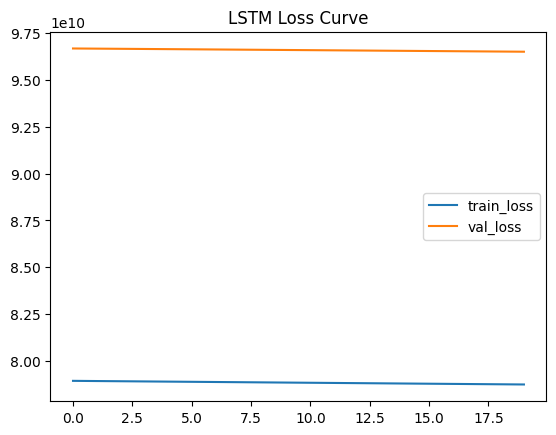

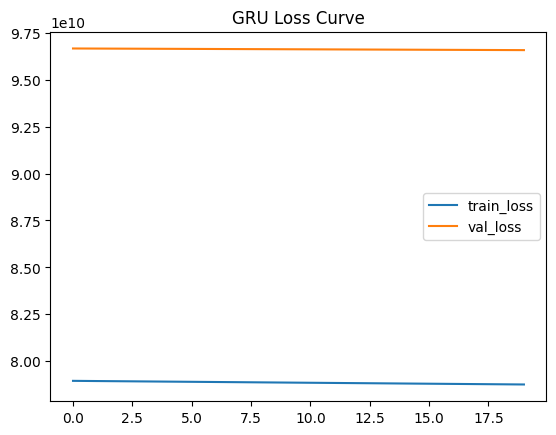

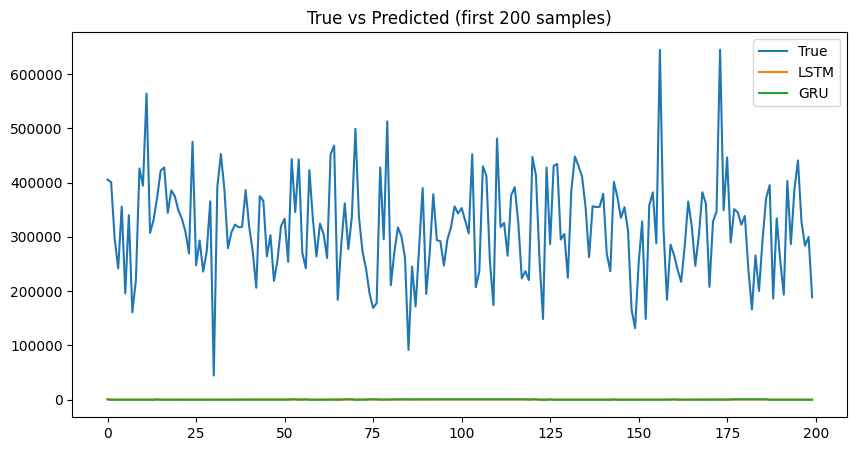

In [ ]:
# =========================
# 4.7 Visualizations
# =========================
plt.plot(history_lstm.history["loss"], label="train_loss")
plt.plot(history_lstm.history["val_loss"], label="val_loss")
plt.title("LSTM Loss Curve")
plt.legend()
plt.show()

plt.plot(history_gru.history["loss"], label="train_loss")
plt.plot(history_gru.history["val_loss"], label="val_loss")
plt.title("GRU Loss Curve")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(y_test_seq[:200], label="True")
plt.plot(y_pred_lstm[:200], label="LSTM")
plt.plot(y_pred_gru[:200], label="GRU")
plt.legend()
plt.title("True vs Predicted (first 200 samples)")
plt.show()


In [ ]:
df

,date,Unnamed: 0,O3 Mean,O3 1st Max Value,O3 1st Max Hour,O3 AQI,CO Mean,CO 1st Max Value,CO 1st Max Hour,CO AQI,...,NO2 AQI,State,year,month,dayofweek,Unnamed: 0_lag1,Unnamed: 0_lag7,Unnamed: 0_lag30,Unnamed: 0_roll7,Unnamed: 0_roll30
17550,2000-01-31,252635.00,0.031779,0.046500,10.250000,50.250000,0.475000,0.725,2.750000,8.250000,...,30.750000,Arizona,2000,1,0,257616.833333,590116.0,336074.000000,282610.869048,294181.578333
17551,2000-02-01,268614.50,0.048470,0.061500,17.000000,90.000000,0.283334,0.350,4.000000,4.000000,...,23.500000,Arizona,2000,2,1,252635.000000,308976.0,253413.333333,276844.940476,294688.283889
17552,2000-02-02,527324.00,0.009765,0.023000,10.000000,21.000000,0.620833,1.100,1.000000,13.000000,...,38.000000,Arizona,2000,2,2,268614.500000,336685.0,238660.666667,304079.083333,304310.395000
17553,2000-02-03,234125.40,0.030165,0.043400,9.800000,41.200000,0.291667,0.380,2.000000,4.200000,...,25.400000,Arizona,2000,2,3,527324.000000,434802.0,548742.666667,275410.997619,293823.152778
17554,2000-02-04,183438.50,0.024324,0.041000,9.500000,37.500000,0.322916,0.450,0.000000,5.500000,...,31.500000,Arizona,2000,2,4,234125.400000,81935.0,290348.600000,289911.497619,290259.482778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393562,2021-09-28,232947.50,0.028118,0.044000,10.500000,48.000000,0.466666,0.650,11.500000,7.500000,...,19.500000,Virginia,2021,9,1,464055.000000,430689.0,603979.500000,250716.957143,304012.240000
393563,2021-09-29,206328.25,0.031353,0.043000,10.000000,50.750000,0.510417,0.625,9.500000,7.250000,...,25.750000,Virginia,2021,9,2,232947.500000,162239.0,99877.000000,257015.421429,307560.615000
393564,2021-09-30,246091.00,0.009529,0.018000,7.000000,17.000000,0.216667,0.400,18.000000,5.000000,...,23.000000,Virginia,2021,9,3,206328.250000,322297.2,190796.000000,246128.821429,309403.781667
394052,2023-01-31,340705.40,0.023659,0.035200,9.200000,32.600000,0.246667,0.300,4.400000,3.400000,...,9.400000,Virginia,2023,1,1,249245.666667,156459.5,432674.000000,364484.973810,339301.037778
